## 1. Importing required Libraries


In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import os
import shutil

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from pathlib import Path
import glob

## 2. Mounting google drive so that the dataset can be brought in for training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Unzipping the dataset to a folder

In [ ]:
!mkdir data-resized
!unzip "/content/drive/MyDrive/dataset-resized.zip" -d "data-resized"

## 4. A number of functions:
> ##### a. train_val - to break the dataset into train and validation sets


>##### b. file_name -  gets file names for a particular type of trash, given indices


> ##### c. move_files - moves group of source files to another folder





In [ ]:
def file_name(waste_type,indices):
    file_names = []
    for i in indices:
      file_names.append(waste_type+str(i)+".jpg") 
    return(file_names)    

def move_files(start_file,folder):
    for file in start_file:
        shutil.move(file,folder)

def train_val(folder,seed1):    
    length = len(os.listdir(folder))
    full_set = list(range(1,length+1))

    # for Training data
    random.seed(seed1)
    training_set = random.sample(list(range(1,length+1)),int(.75*length))

    # Validation data
    validation_set = list(set(full_set)-set(training_set))

    return(training_set,validation_set)


## 5. Breaking the data into training and validation sets

In [ ]:
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

for subset in subsets:
    for i in waste_types:
        folder = os.path.join('data',subset,i)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
for i in waste_types:
    folder = os.path.join('data-resized/dataset-resized',i)
    train_ind, valid_ind = train_val(folder,1)
    
    # Training set
    train_names = file_name(i,train_ind)
    train_source_files = [os.path.join(folder,name) for name in train_names]
    train_dest = "data/train/"+i
    move_files(train_source_files,train_dest)
    
    # Validation set
    valid_names = file_name(i,valid_ind)
    valid_source_files = [os.path.join(folder,name) for name in valid_names]
    valid_dest = "data/valid/"+i
    move_files(valid_source_files,valid_dest)

In [ ]:
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=32)

## 6. Looking at the subtypes of trash
 *(Here **'trash'** is for any other unspecified category)*

In [ ]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


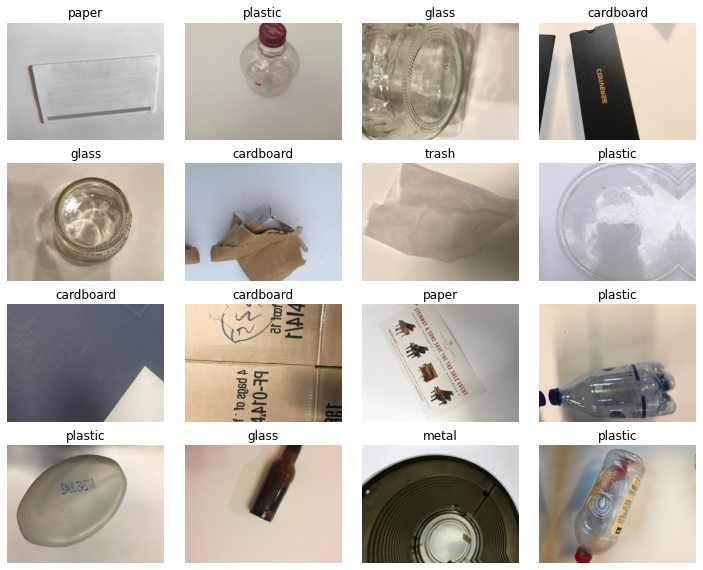

In [ ]:
data.show_batch(rows=4,figsize=(10,8))

## 7. Creating model using Resnet18

In [ ]:
learn = create_cnn(data,models.resnet18,metrics=[error_rate, accuracy])

In [ ]:
learn.model

## 8. Training the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


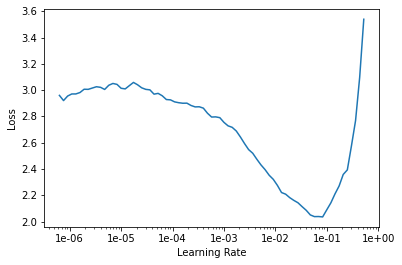

In [ ]:
start_lr=1e-7
end_lr=1e1
learn.lr_find(start_lr, end_lr)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20,max_lr=5.5e-03)

## 9. Testing the model

In [ ]:
from IPython.display import Image, display

model = learn.model
model = model.cuda()
import glob

/content/drive/MyDrive/0-Test/test1.jpg
Prediciton: paper
Throw in the Yellow Dustbin!


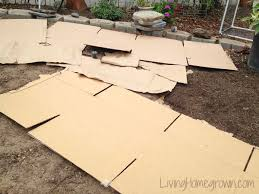



/content/drive/MyDrive/0-Test/test5.jpg
Prediciton: paper
Throw in the Yellow Dustbin!


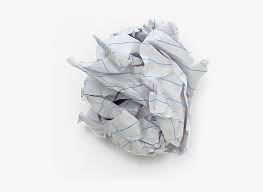



/content/drive/MyDrive/0-Test/test6.jpg
Prediciton: plastic
Throw in the Blue Dustbin!


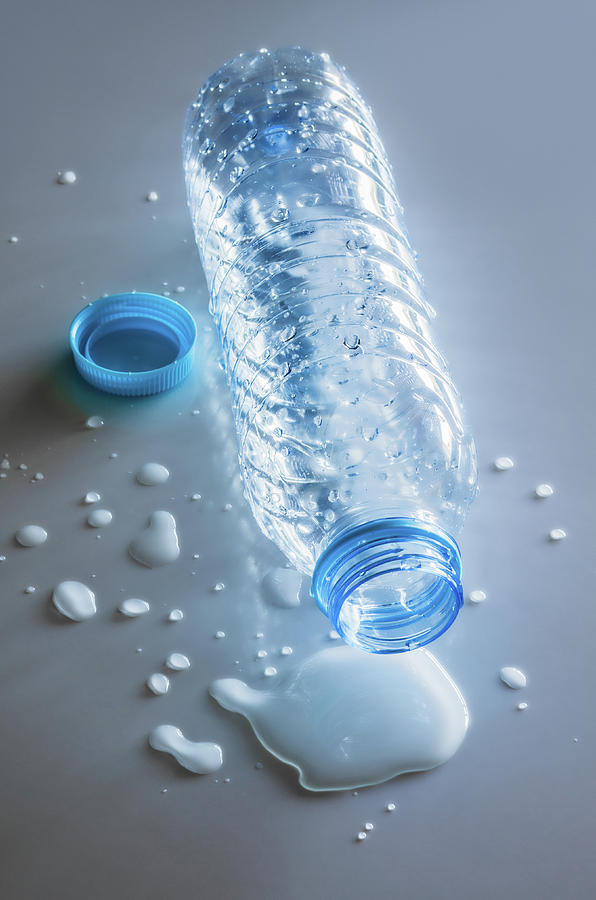



/content/drive/MyDrive/0-Test/test3.jpg
Prediciton: metal
Throw in the Blue Dustbin!


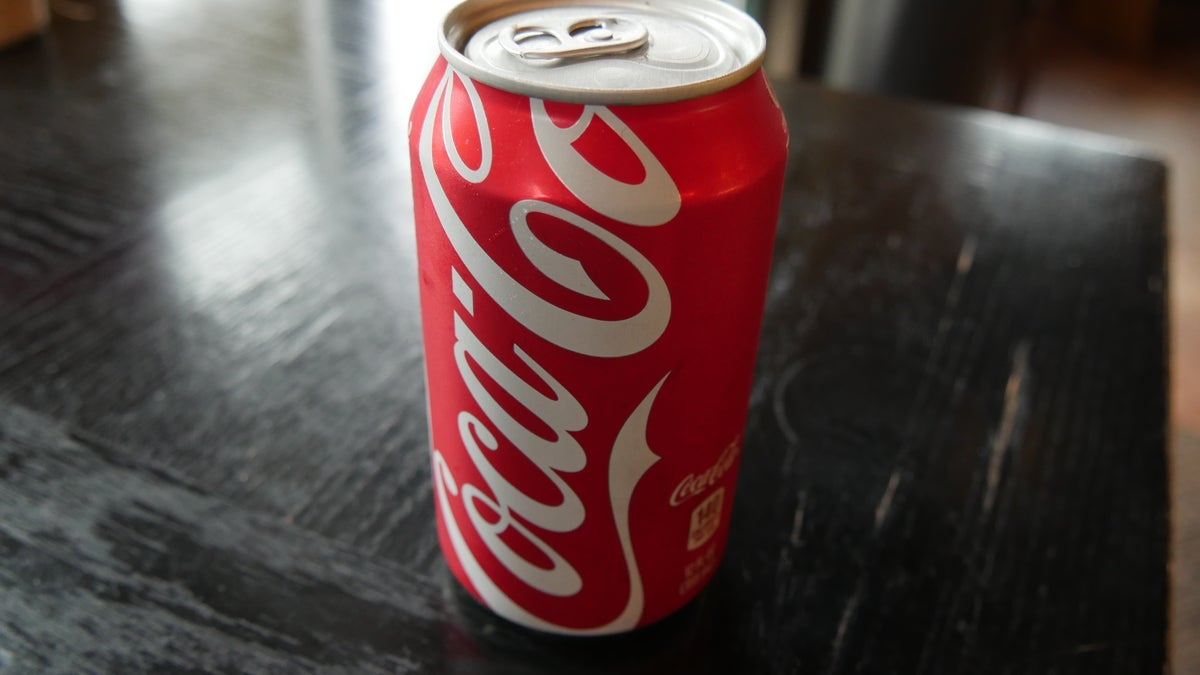



/content/drive/MyDrive/0-Test/test2.jpg
Prediciton: glass
Throw in the Yellow Dustbin!


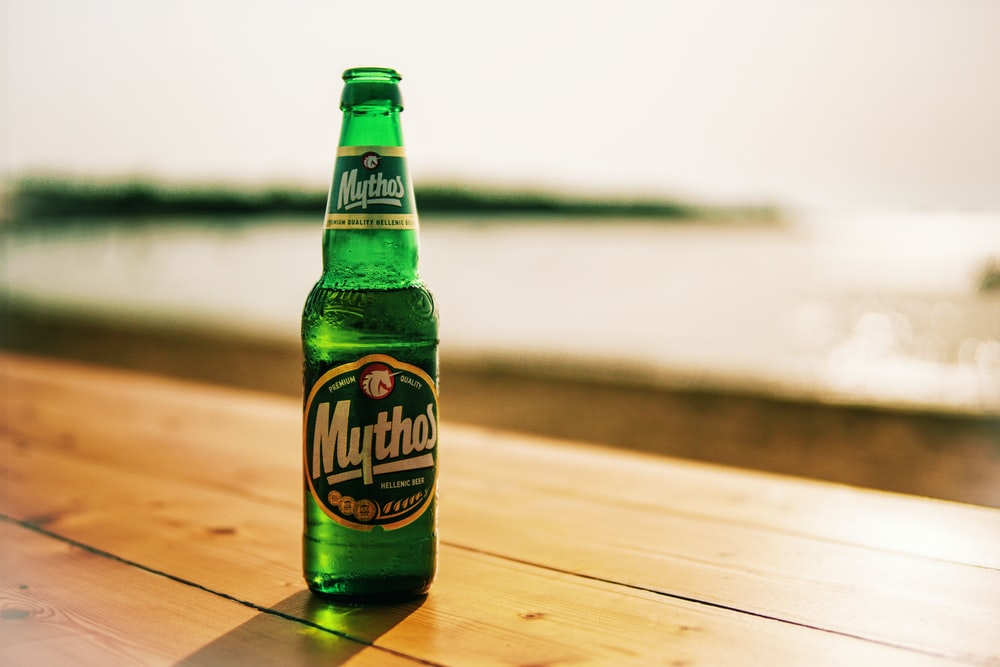

In [ ]:
for imageName in glob.glob('/content/drive/MyDrive/0-Test/*.jpg'):
    print(imageName)
    img = open_image(imageName)
    prediction = learn.predict(img)
    print('Prediction: '+ str(prediction[0]))
    prediction=str(prediction[0])
    if (prediction=='paper' or prediction=='glass' or prediction=='cardboard'):
      print("Throw in the Yellow Dustbin!")
    elif (prediction=='plastic' or prediction=='metal'):
      print("Throw in the Blue Dustbin!")
    else:
      print("Throw in the Green Dustbin!")

    display(Image(filename=imageName, width=300, height=200))
    print("\n")


## Let's try a live image!

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


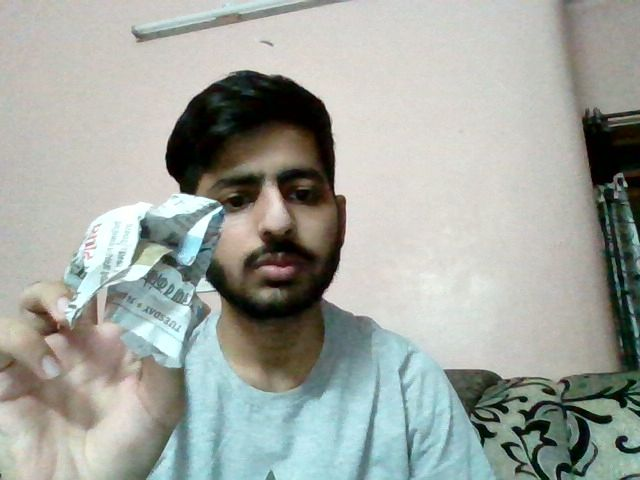

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

/content/photo.jpg
Prediciton: paper
Throw in the Green Dustbin!


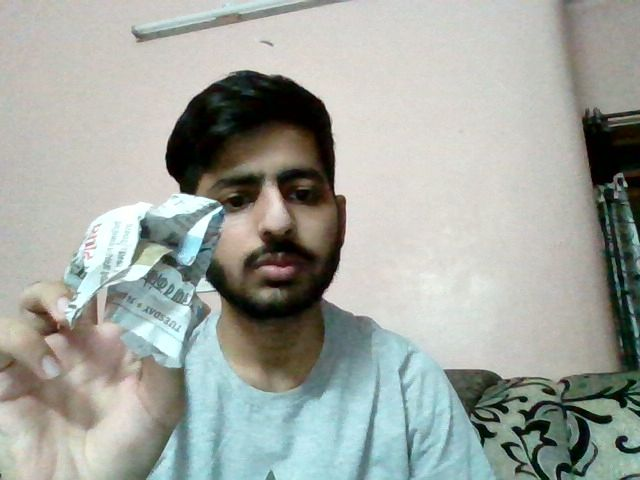

In [ ]:
for imageName in glob.glob('/content/photo.jpg'):
    print(imageName)
    img = open_image(imageName)
    prediction = learn.predict(img)
    #print(prediction)
    print('Prediction: '+ str(prediction[0]))

    if (prediction=='paper' or prediction=='glass'):
      print("Throw in the Yellow Dustbin!")
    elif (prediction=='plastic' or prediction=='metal'):
      print("Throw in the Blue Dustbin!")
    else:
      print("Throw in the Green Dustbin!")
      
    display(Image(filename=imageName))
    print("\n")